In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import imageio
from shutil import copy2, rmtree
from IPython.display import clear_output
plt.style.use('seaborn-whitegrid')

In [2]:
data_path = r'C:\Users\jupol\Desktop\TensorTut\covid\legacyCovidMexico'
data_dir = os.listdir(data_path)

In [16]:
sufx_dict = {
    'Deaths': 'Casos_Diarios_Estado_Nacional_Defunciones_2020',
    'Confirmed': 'Casos_Diarios_Estado_Nacional_Confirmados_2020',
    'Suspicious': 'Casos_Diarios_Estado_Nacional_Sospechosos_2020',
    'Negatives': 'Casos_Diarios_Estado_Nacional_Negativos_2020',
    'Actives': 'COVID19MEXICO.csv'
}

def clean_nan(array):
    if type(array) == list:
        array = np.asarray(array) 
    not_nan_array = ~ np.isnan(array)
    return array[not_nan_array]
def make_mp4(state,dtype,max_date):
    
    for _ in range(30):
        copy2(f'plots/{state}/cummulative/{dtype}/{max_date}.jpg', f'plots/{state}/cummulative/{dtype}/{max_date}_{_}.jpg')
        copy2(f'plots/{state}/discrete/{dtype}/{max_date}.jpg', f'plots/{state}/discrete/{dtype}/{max_date}_{_}.jpg')

    if not os.path.exists(f'results/{state}'):
        os.makedirs(f'results/{state}')

    cum_images = []

    for filename in os.listdir(f'plots/{state}/cummulative/{dtype}'):
        cum_images.append(imageio.imread(os.path.join(f'plots/{state}/cummulative/{dtype}',filename)))
    imageio.mimsave(f'results/{state}/{dtype}_cummulative_{state}.mp4', cum_images)

    dis_images = []

    for filename in os.listdir(f'plots/{state}/discrete/{dtype}'):
        dis_images.append(imageio.imread(os.path.join(f'plots/{state}/discrete/{dtype}',filename)))
    imageio.mimsave(f'results/{state}/{dtype}_discrete_{state}.mp4', dis_images)
    
    rmtree('plots')

In [19]:
def plot_single_discrete(index, plot_index, plot_data, state, file, dtype, max_day,trim):
    plt.close('all')
    plt.rcParams['figure.figsize'] = (14,6)
    plt.rcParams['figure.constrained_layout.use']=True
    
    plt.title(f'Daily {dtype} Cases for Covid19 in {state}', fontsize = 20)
    plt.ylabel(f'Number of {dtype} Cases', fontsize=18)
    plt.ylim(0,max_day+(max_day*0.3))
    plt.xlim(trim,len(plot_index))
    plt.xticks(rotation=70)
    plt.bar(plot_index,plot_data, label = f'Number of {dtype} Cases: {max(clean_nan(np.array(plot_data)))}')
    plt.suptitle(f'{calendar.month_name[int(file[-8:-6])]} {file[-6:-4]}', fontsize=22)
    plt.legend(loc=0,fontsize=20)
    plt.savefig(f'plots/{state}/discrete/{dtype}/{file[-12:-8]+"-"+file[-8:-6]+"-"+file[-6:-4]}.jpg')

def plot_single_cummulative(index, plot_index, plot_data, state, file, dtype, max_cummulative,trim):
    cummulative_record = []
    last_valid = int()
    for i in plot_data:

        if len(cummulative_record) == 0:
            if not np.isnan(i):
                cummulative_record.append(i)
                last_valid = i
            else:
                cummulative_record.append(np.nan)
                last_valid = 0
        else:
            if not np.isnan(i):
                cummulative_record.append(i+last_valid)
                last_valid += i

            else:
                cummulative_record.append(np.nan)
            
    plt.close('all')
    plt.rcParams['figure.figsize'] = (14,6)
    plt.rcParams['figure.constrained_layout.use']=True
    
    plt.title(f'Cummulative register of {dtype} Cases by Covid19 in {state}', fontsize = 20)
    plt.ylabel(f'Number of {dtype} Cases', fontsize=18)
    plt.ylim(0,max_cummulative+(max_cummulative*0.3))
    plt.xticks(rotation=70)
    plt.xlim(trim,len(plot_index))
    plt.plot(plot_index,cummulative_record, label=dtype+': '+str(max(clean_nan(cummulative_record))))
    plt.suptitle(f'{calendar.month_name[int(file[-8:-6])]} {file[-6:-4]}', fontsize=22)
    plt.fill_between(plot_index, cummulative_record, color='b', alpha=.2)
    plt.legend(loc=0, fontsize=18)
    plt.savefig(f'plots/{state}/cummulative/{dtype}/{file[-12:-8]+"-"+file[-8:-6]+"-"+file[-6:-4]}.jpg')

def plot_multi_discrete(index, plot_index, plot_data, days, dtypes, state, max_day,trim):
    
    today = calendar.month_name[int(days[0][-8:-6])]+'-'+ days[0][-6:-4]
    plt.close('all')
    plt.rcParams['figure.figsize'] = (14,6)
    plt.rcParams['figure.constrained_layout.use']=True

    plt.title(f'Daily {dtypes} Cases for Covid19 in {state}', fontsize = 20)
    plt.ylabel(f'Number of Cases', fontsize=18)
    plt.ylim(0,max_day+(max_day*0.3))
    plt.xlim(trim,len(plot_index))
    plt.xticks(rotation=70)
    for data in plot_data.keys():
        plt.bar(plot_index,plot_data[data], label = f'Number of {data} Cases: {max(clean_nan(np.array(plot_data[data])))}',alpha=0.4)
    plt.suptitle(f'{today}', fontsize=22)
    plt.legend(loc=0,fontsize=20)
    plt.savefig(f'plots/{state}/discrete/{dtypes}/{days[0][-12:-8]}-{days[0][-8:-6]}-{days[0][-6:-4]}.jpg')

def plot_multi_cummulative(index, plot_index, plot_data, days, dtypes, state, max_cummulative,trim):
    
    today = calendar.month_name[int(days[0][-8:-6])]+'-'+ days[0][-6:-4]
    cum_data = {key:[] for key in plot_data.keys()}
    
    for key in plot_data.keys():
    
        last_valid = int()
        for i in plot_data[key]:

            if len(cum_data[key]) == 0:
                if not np.isnan(i):
                    cum_data[key].append(i)
                    last_valid = i
                else:
                    cum_data[key].append(np.nan)
                    last_valid = 0
            else:
                if not np.isnan(i):
                    cum_data[key].append(i+last_valid)
                    last_valid += i

                else:
                    cum_data[key].append(np.nan)
            
    plt.close('all')
    plt.rcParams['figure.figsize'] = (14,6)
    plt.rcParams['figure.constrained_layout.use']=True
    
    plt.title(f'Cummulative register of {dtypes} Cases by Covid19 in {state}', fontsize = 20)
    plt.ylabel(f'Number of {dtypes} Cases', fontsize=18)
    plt.ylim(0,max_cummulative+(max_cummulative*0.3))
    plt.xticks(rotation=70)
    plt.xlim(trim,len(plot_index))
    for key in cum_data:
        plt.plot(plot_index,cum_data[key], label=key+': '+str(max(clean_nan(cum_data[key]))))
        plt.fill_between(plot_index, cum_data[key], alpha=.2)
        
    plt.suptitle(f'{calendar.month_name[int(days[0][-8:-6])]} {days[0][-6:-4]}', fontsize=22)
    plt.legend(loc=0, fontsize=18)
    
    plt.savefig(f'plots/{state}/cummulative/{dtypes}/{days[0][-12:-8]}-{days[0][-8:-6]}-{days[0][-6:-4]}.jpg')

In [5]:
def make_plots(index, plot_index, state, file, dtype, max_day, max_cummulative,trim):
    
    if not os.path.exists(f'plots/{state}/cummulative/{dtype}'):
        os.makedirs(f'plots/{state}/cummulative/{dtype}')
        
    if not os.path.exists(f'plots/{state}/discrete/{dtype}'):
        os.makedirs(f'plots/{state}/discrete/{dtype}')
        
    data = pd.read_csv(os.path.join(data_path,file))
    data = data[data['nombre'] == state]
    dates = pd.to_datetime(data.columns[3:], dayfirst=True)
    
    plot_data = []
                       
    for day in index:
        try:
            plot_data.append(data[str(day)[-11:-9]+str(day)[-15:-11]+str(day)[:4]].values[0])
        except:
            plot_data.append(np.nan)
    
    plot_single_discrete(index, plot_index, plot_data, state, file, dtype, max_day,trim)
    
    plot_single_cummulative(index, plot_index, plot_data, state, file, dtype, max_cummulative,trim)    
    
    print(f'Plots of {dtype} ready for day: {calendar.month_name[int(file[-8:-6])]} {file[-6:-4]}')

def make_multi_plots(index, plot_index, state, days, sufx_items, max_day, max_cummulative,trim,dtypes):
    
    if not os.path.exists(f'plots/{state}/cummulative/{dtypes}'):
        os.makedirs(f'plots/{state}/cummulative/{dtypes}')
        
    if not os.path.exists(f'plots/{state}/discrete/{dtypes}'):
        os.makedirs(f'plots/{state}/discrete/{dtypes}')
    
    data = [pd.read_csv(os.path.join(data_path,x)) for x in days]
    data = [x[x['nombre'] == state] for x in data]
        
    plot_data = {key:[] for key in sufx_items.keys()}
    
    
    
    for ind, key in enumerate(plot_data.keys()):
        for day in index:
            try:
                plot_data[key].append(data[ind][str(day)[-11:-9]+str(day)[-15:-11]+str(day)[:4]].values[0])
            except:
                plot_data[key].append(np.nan)
    
    plot_multi_discrete(index, plot_index, plot_data, days, dtypes, state, max_day,trim)
    plot_multi_cummulative(index, plot_index, plot_data, days, dtypes, state, max_cummulative,trim)
    print(f'Plots of {dtypes} ready for day: {calendar.month_name[int(days[0][-8:-6])]} {days[0][-6:-4]}')

In [6]:
def get_indexes(sufx, data_dir, state):

    newest_date = max(set([ pd.to_datetime(f'2020-{date[-8:-6]}-{date[-6:-4]}',format = "%Y/%m/%d") for date in data_dir if date.startswith(sufx)]))
    oldest_date = min(set([ pd.to_datetime(f'2020-{date[-8:-6]}-{date[-6:-4]}',format = "%Y/%m/%d") for date in data_dir if date.startswith(sufx)]))

    newest_date = pd.read_csv(os.path.join( data_path, sufx + str(newest_date)[-14:-12]+str(newest_date)[-11:-9]+'.csv') )
    oldest_date = pd.read_csv(os.path.join( data_path, sufx + str(oldest_date)[-14:-12]+str(oldest_date)[-11:-9]+'.csv') )

    max_day = max(newest_date[newest_date['nombre'] == state].values[0][3:])
    max_cummulative = sum(newest_date[newest_date['nombre'] == state].values[0][3:])
    
    index = pd.date_range(start= pd.to_datetime(oldest_date.columns[3], dayfirst=True), end = pd.to_datetime(newest_date.columns[-1], dayfirst=True))
    plot_index = [calendar.month_name[int(str(x)[5:-12])] + ' / ' + str(x)[8:-9]  for x in index]
        
    return index, plot_index, max_day, max_cummulative

def get_multi_indexes(files, data_dir, state, sufx_items):
    
    newest_date = max(set([ pd.to_datetime(f'2020-{date[-8:-6]}-{date[-6:-4]}',format = "%Y/%m/%d") for date in files[list(sufx_items.keys())[0]]]))
    oldest_date = min(set([ pd.to_datetime(f'2020-{date[-8:-6]}-{date[-6:-4]}',format = "%Y/%m/%d") for date in files[list(sufx_items.keys())[0]]]))
    
    longest_data_check = 0
    longest_data = ''
    max_day = 0
    max_cummulative = 0
    
    for dtype in files.keys():
        
        data_check = pd.read_csv(os.path.join( data_path, sufx_items[dtype] + str(newest_date)[-14:-12]+str(newest_date)[-11:-9]+'.csv'))
        max_discrete = max(data_check[data_check['nombre'] == state].values[0][3:])
        sum_cummulative = sum(data_check[data_check['nombre'] == state].values[0][3:])
        
        if len(data_check.columns[3:]) > longest_data_check:
            longest_data_check == len(data_check.columns[3:])
            longest_data = data_check[data_check['nombre'] == state]
            
        if  max_discrete > max_day:
            max_day = max_discrete
        if sum_cummulative > max_cummulative:
            max_cummulative = sum_cummulative
    
    index = pd.date_range(start= pd.to_datetime(longest_data.columns[3], dayfirst=True), end = pd.to_datetime(longest_data.columns[-1], dayfirst=True))
    plot_index = [calendar.month_name[int(str(x)[5:-12])] + ' / ' + str(x)[8:-9]  for x in index]
    
    return index, plot_index, max_day, max_cummulative

In [7]:
def make_animation(data_dir, dtype, state, trim=0):
    
    if type(dtype) == list :
        
        sufx_items = {key:sufx_dict[key] for key in dtype}
        
        dtypes_list = [x for x in sufx_items.keys()]
        dtypes=''
        for i in dtypes_list:
            dtypes += i+' '
        dtypes = dtypes[:-1]
        
        files = {}
        for key in sufx_items.keys():
            files[key] = [file for file in data_dir if file.startswith(sufx_items[key])]
        
        assert len(set([len(files[key]) for key in files.keys()])) == 1
        
        index, plot_index, max_day, max_cummulative = get_multi_indexes(files, data_dir, state, sufx_items)
        
        for instance in range(len(files[dtype[0]])):
            days = []
            for key in files.keys():
                days.append(files[key][instance])
            
            make_multi_plots(index, plot_index, state, days, sufx_items, max_day, max_cummulative,trim, dtypes)
            clear_output(wait=True)
        
        plots  = [x[:-4] for x in os.listdir(f'plots/{state}/cummulative/{dtypes}')]
        max_date = str(max(pd.to_datetime(plots)))[:10]
        
        make_mp4(state,dtypes,max_date)
        
        
    else:
        
        sufx = sufx_dict[dtype]
    
        index, plot_index, max_day, max_cummulative = get_indexes(sufx, data_dir, state)
        files = [file for file in data_dir if file.startswith(sufx)]

        for file in files:
            make_plots(index, plot_index, state, file, dtype, max_day, max_cummulative,trim)
            clear_output(wait=True)

        plots  = [x[:-4] for x in os.listdir(f'plots/{state}/cummulative/{dtype}')]
        max_date = str(max(pd.to_datetime(plots)))[:10]
        
        make_mp4(state,dtype,max_date)
        

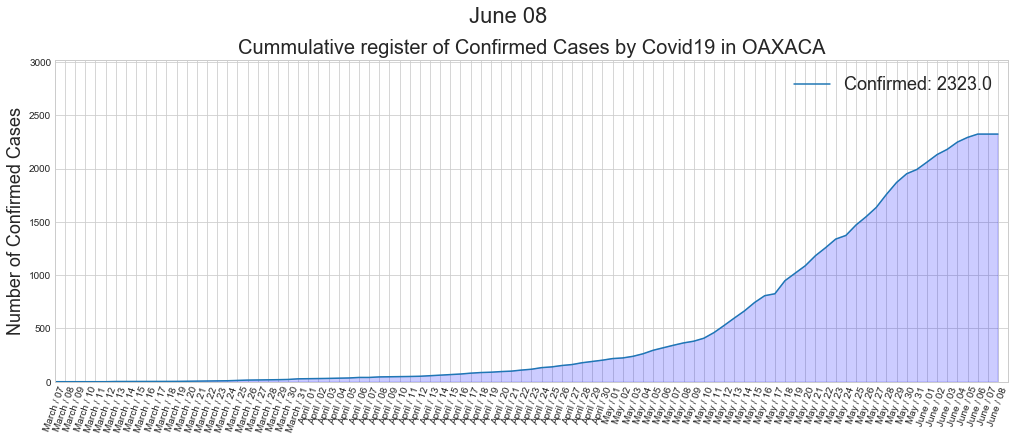

In [30]:
make_animation(data_dir = data_dir,
               dtype     = 'Confirmed',
               state    = 'OAXACA',
               trim=60)

In [9]:
d = {}
for ind,i in enumerate(c):
    d[i]= b[:,ind]

NameError: name 'c' is not defined